In [5]:
import requests
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
import pandas as pd
import csv
import time
import operator
import re

In [6]:
#m_url ="https://www.nytimes.com/topic/subject/construction-accidents"
m_url ="https://www.nytimes.com/search?dropmab=false&endDate=20200229&query=%22construction%22%20accident&sort=best&startDate=20000101"

In [7]:
session = requests.Session()
req=session.get(m_url) #default is s_url
soup = BeautifulSoup(req.text, 'html.parser')

#stream-panel > div.css-13mho3u > ol > li:nth-child(2) > div > div.css-1l4spti > a
#stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a


In [1817]:

chrome_options = webdriver.ChromeOptions
#chrome_options.add_argument("--incognito")
driver = webdriver.Chrome(executable_path='/Users/macbookpro/Desktop/Project/Construction_analysis/chromedriver')

link = []
driver.get(m_url)
time.sleep(3)
for i in range(100) :
    a = driver.page_source
    b = BeautifulSoup(a, 'html.parser')
    #stream-panel > div.css-13mho3u > ol > li:nth-child(1) > div > div.css-1l4spti > a
    #stream-panel > div.css-13mho3u > ol > li > div > div.css-1l4spti > a
    #site-content > div > div:nth-child(2) > div.css-46b038 > ol > li:nth-child(1) > div > div > div > a
    c = b.select('#site-content > div >div>div> ol >li> div > div > div > a')
    
    for j in range(len(c)) :
        if c[j].attrs['href'] not in link :
            link.append(c[j].attrs['href'])
        else :
            pass
    
    driver.find_element_by_xpath('//*[@id="site-content"]/div/div[2]/div[2]/div/button').click()
    time.sleep(3)

#link

KeyboardInterrupt: 

In [1818]:
link_source = link 

a_link = link

print(len(a_link))


1010


In [1819]:
diff_link = []

#delete unsupported news 
for i in range (len(a_link)) :
    print(a_link[i])
    if a_link[i][1] != '2':
        
        diff_link.append(a_link[i])
            
    else : 
        continue

for j in range(len(diff_link)):
    if diff_link[j] in a_link:
        a_link.remove(diff_link[j])
        
#a_link


/2020/02/17/nyregion/construction-deaths-latinos-nyc.html?searchResultPosition=1
/2020/01/30/nyregion/nyc-scaffolding-building-facades.html?searchResultPosition=2
/2019/11/22/nyregion/nyc-dob-surprise-inspectors.html?searchResultPosition=3
/2019/11/29/us/hard-rock-hotel-worker-immigration.html?searchResultPosition=4
/2007/09/13/nyregion/13mbrfs-DEATHS.html?searchResultPosition=5
/2015/06/03/nyregion/fatal-construction-accidents-are-rising-in-new-york.html?searchResultPosition=6
/2006/11/22/nyregion/fatal-construction-accidents-in-the-city-rise-sharply-over-12.html?searchResultPosition=7
/2006/11/22/nyregion/22construct.html?searchResultPosition=8
/2007/05/05/nyregion/05cave.html?searchResultPosition=9
https://cityroom.blogs.nytimes.com/2008/04/29/more-construction-accidents-2-workers-critically-injured/?searchResultPosition=10
/2002/08/27/nyregion/city-allows-work-to-resume-at-construction-accident-site.html?searchResultPosition=11
https://cityroom.blogs.nytimes.com/2007/08/23/new-scaf

In [1820]:
## This is main source for analyzing article

class ArticleInfo():
    
    def __init__(self, s_url) :
        
        session = requests.Session()
        req=session.get(s_url)
        self.soup = BeautifulSoup(req.text, 'html.parser')
    
    
    def article_body(self) :
        body = self.soup.find('div', {'class' : 'StoryBodyCompanionColumn'})
        finalContent =''
    
        if body is not None :
            for itcontents in self.soup.findAll('p'):
                if itcontents == None :
                    continue
                content = itcontents.getText()
                content = re.sub(r"\n+", "", content)
                finalContent +=content
        else :
            return False
        
        return finalContent

##reference: https://github.com/subhendusethi/nytimes-article-crawler/blob/master/crawler/nytimescrawler.py    

    def article_title(self):
        titles = self.soup.select('title',{"data-rh":"true"})
        for title in titles:
            title = title.getText()
            break
        return title

    def article_date(self) :
  
        date = self.soup.find('li',{'class':'date'})
        if date != None :
            date = date.getText()
            
        else :
            date = self.soup.find('meta',{'name':'pdate'})
            if date !=None :
                date = date.get('content')
                if date !=None :
                    date = str(date)
                else:
                    none= "none"
                    datelist.append(none)
                
        return date

 

In [1821]:
titles =[]
bodies =[]
datelist=[]

for s_url in a_link :
    s_url = 'https://www.nytimes.com'+s_url
    ob = ArticleInfo(s_url)
    
    body =ob.article_body()
    bodies.append(body)
    
    date = ob.article_date()
    datelist.append(date)
    
    title = ob.article_title()
    titles.append(title)

In [452]:
#bodies

### Start Tokenize words with nltk

In [1823]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.probability import ConditionalFreqDist
from gensim.models import Word2Vec


In [1824]:

#1. make lower case, regulazation
l_bodies=[]
for body in bodies :
    
    body = str(body).lower()
    l_bodies.append(body)

    
#2. removing stop words, tokenize with postagging
stop_words = set(stopwords.words('english'))

token_sentence = []
for words in l_bodies:
    word_tokens= word_tokenize(words)
    filter_sentence = [fw for fw in word_tokens if not fw in stop_words]
    #filter_sentence = [fs for fs in word_tokens if not fs in remove_list]
    
    for n in range(len(filter_sentence)) :
        if filter_sentence[n] == 'collapsed' :
            filter_sentence[n]  = 'collapse'
        elif filter_sentence[n] == 'buildings':
            filter_sentence[n] = 'building'
        #elif filter_sentence[n] == 'fell' :
        #   filter_sentence[n] = 'fall'
       
    ## fall + fell => fall , collapsed +collapse => collapse
    #filter_sentence = nltk.pos_tag(filter_sentence)
    token_sentence.append(filter_sentence)
    
#token_sentence
#print(l_bodies)



In [1825]:
len(token_sentence)

871

In [1826]:
#frequency 

cnt_fire =0 
cnt_fall =0
cnt_collapse =0 
for token in token_sentence :
    if 'fire' in token :
        cnt_fire +=1
    if 'collapse' in token :
        cnt_collapse +=1
    if 'fell' in token :
        cnt_fall +=1
        
print(cnt_fire, cnt_fall, cnt_collapse)
print(len(token_sentence))

197 231 283
871


In [1827]:
#print(sentences)
model = Word2Vec(token_sentence, size = 400, window=5, min_count=200, workers=3, sg=0, iter=5)

In [1828]:
model.similarity('fell','fire')  ## similarity between words

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.70311344

In [1829]:
model.similarity('collapse','fell') 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.952242

In [1830]:
#model.most_similar('fire')
sim_list = model.similar_by_vector('building', topn=50, restrict_vocab=None)

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


In [1831]:
df_sl = pd.DataFrame(sim_list)
df_sl
df_sl.to_csv('building_sim.csv')

In [1811]:
sim_list

[('cause', 0.9317953586578369),
 ('authorities', 0.8755030632019043),
 ('investigators', 0.8679304718971252),
 ('said.the', 0.8652119636535645),
 ('police', 0.8581023216247559),
 ('taken', 0.8578938841819763),
 ('scene', 0.8570490479469299),
 ('chief', 0.8314235210418701),
 ('injuries', 0.8297286033630371),
 ('floor', 0.8166186809539795),
 ('officials', 0.8120682239532471),
 ('hospital', 0.8049041032791138),
 ('night', 0.7762022018432617),
 ('truck', 0.7701035737991333),
 ('dead', 0.7621203064918518),
 ('spokesman', 0.7565330862998962),
 ('debris', 0.7527214288711548),
 ('yesterday', 0.7505488395690918),
 ('ground', 0.744280993938446),
 ('crash', 0.7397264242172241),
 ('thursday', 0.7311388254165649),
 ('friday', 0.724968433380127),
 ('collapse', 0.724821150302887),
 ('driver', 0.7149516940116882),
 ('accident', 0.714523434638977),
 ('man', 0.7125470042228699),
 ('concrete', 0.7086805105209351),
 ('across', 0.7071232795715332),
 ('left', 0.7042842507362366),
 ('investigation', 0.702754

In [1758]:
#data ={"Date":datelist, "Title": titles, "Body":bodies,"Link" :a_link}
#df= pd.DataFrame(data)

#df['Date']=pd.to_datetime(df.Date)
#df.sort_values(by='Date')
#df.to_excel('result_0301.xlsx')
#df.to_csv('/Users/macbookpro/Desktop/Project/Cosntruction_article/reslut_0301.csv', index= False,)


In [1759]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [1760]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from umap import UMAP

In [1832]:
reducer = UMAP(n_neighbors =5, min_dist =0.1, n_components = 2, verbose = True)

In [1833]:
len(token_sentence)

871

In [1834]:
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [1835]:
X_l = list(model.wv.vocab)

In [1836]:
X.shape

(289, 400)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sat Mar 21 20:07:01 2020 Finding Nearest Neighbors
Sat Mar 21 20:07:01 2020 Finished Nearest Neighbor Search
Sat Mar 21 20:07:01 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Mar 21 20

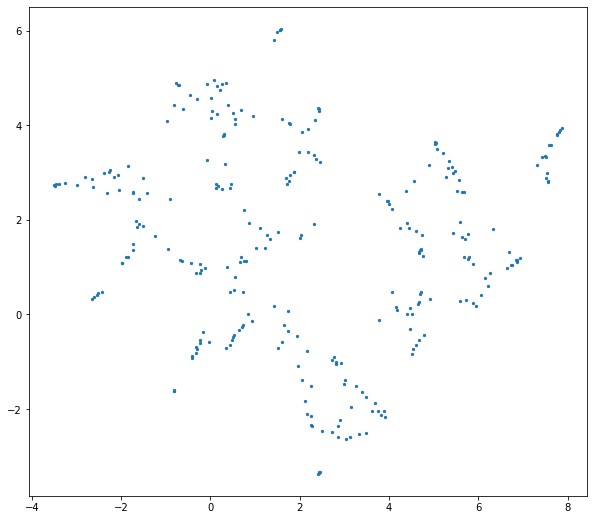

In [1837]:
cluster_embedding = reducer.fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1],s=5,cmap='tab10')

In [1838]:
len(X)

289

In [1839]:
df = pd.DataFrame(cluster_embedding)

In [1840]:
import pandas as pd

In [1841]:
df

,0,1
0,-0.823775,4.428846
1,4.508234,0.008650
2,1.428750,0.170066
3,-1.508595,2.884514
4,2.730718,-0.974266
...,...,...
284,-2.632345,2.684350
285,-3.257382,2.774739
286,2.058281,3.850908
287,-3.397875,2.759039


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0, flags=flags)


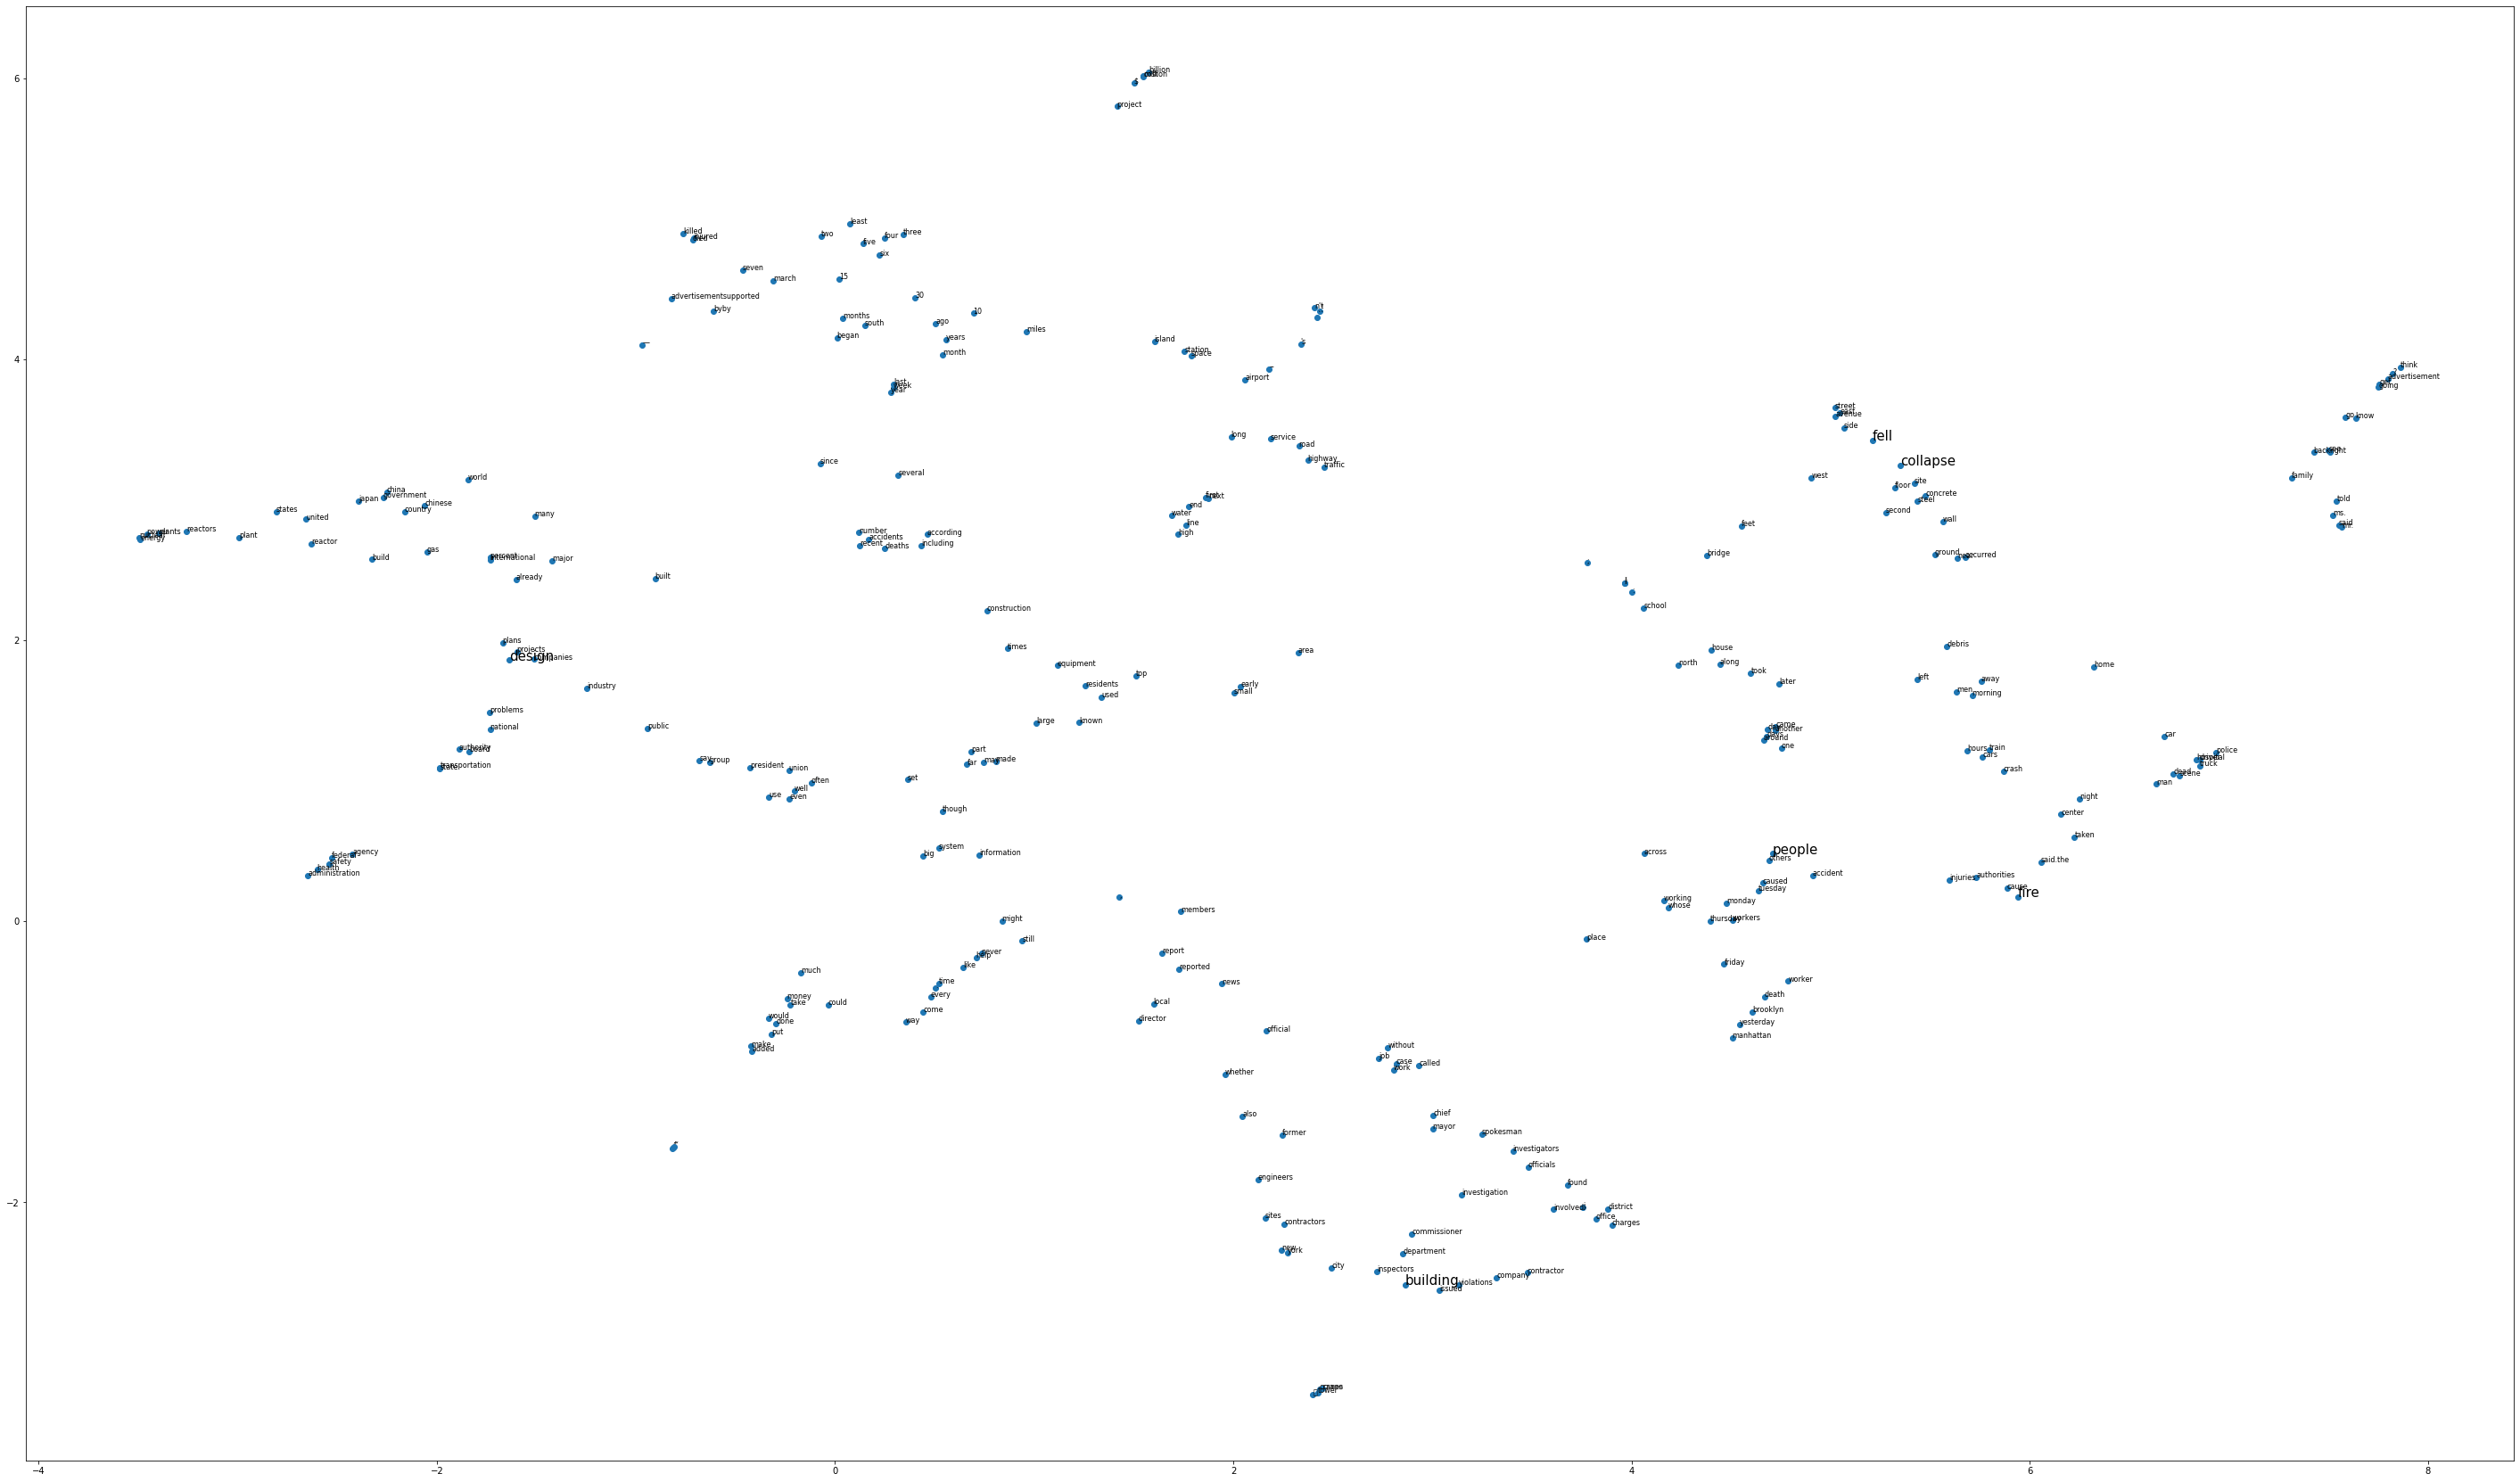

In [1842]:
fig = plt.figure()
fig.set_size_inches(50,30)
ax = fig.add_subplot(1,1,1)

ax.scatter(df[0],df[1])

for i, txt in enumerate(X_l):
    
    if txt == 'fire' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='collapse' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='building' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='fell' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='people' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    elif txt =='design' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=15)
    else :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
plt.savefig('fire_word2vec.png')

In [453]:
for i, txt in enumerate(X_l) :
    print (i,txt)

In [744]:
X_l

['advertisementsupported',
 'workers',
 ',',
 'many',
 'job',
 'new',
 'york',
 'city',
 'safety',
 'week',
 'accident',
 '’',
 'said',
 'construction',
 'site',
 'working',
 '.',
 'told',
 'years',
 'company',
 'would',
 'another',
 'next',
 '“',
 '”',
 'ms.',
 'killed',
 'floor',
 'building',
 'one',
 'people',
 '10',
 'died',
 'accidents',
 'last',
 'year',
 'according',
 'group',
 'department',
 'buildings',
 'number',
 'deaths',
 'four',
 'death',
 'sites',
 'like',
 'mr.',
 'left',
 '30',
 'percent',
 'union',
 'think',
 'district',
 'contractors',
 'take',
 'issued',
 'work',
 'contractor',
 'also',
 'brooklyn',
 '$',
 'investigation',
 'several',
 'morning',
 'early',
 'make',
 'go',
 'school',
 'three',
 'five',
 'first',
 'day',
 'days',
 'see',
 'said.the',
 'two',
 'family',
 'members',
 'united',
 'states',
 'made',
 'way',
 'time',
 'including',
 'around',
 'involved',
 'second',
 'worker',
 'hours',
 'men',
 'done',
 'help',
 'long',
 'seven',
 'could',
 'scene',
 'proje

In [745]:
df_2 = pd.DataFrame(X_l)

In [746]:
df_2

,0
0,advertisementsupported
1,workers
2,","
3,many
4,job
...,...
284,reactor
285,reactors
286,airport
287,plants


In [748]:
df_2.to_excel('word_list.xlsx')

In [1506]:
with open('word_list.csv', newline='') as csvfile:
    noise_word = csv.reader(csvfile, delimiter =',')
    noise_word_ls = list(noise_word)

print(noise_word_ls)    

remove_list =[]
for i in range(len(noise_word_ls)) :
    remove_list.append(noise_word_ls[i][0])


[['\ufeffadvertisementsupported'], [','], ['’'], ['said'], ['.'], ['told'], ['“'], ['”'], ['ms.'], ['mr.'], ['$'], [';'], ['—'], ['advertisement'], [':'], ['j.'], ['('], [')'], ["'s"], ['``'], ["''"], ["n't"], ['--']]


In [1507]:
remove_list

['\ufeffadvertisementsupported',
 ',',
 '’',
 'said',
 '.',
 'told',
 '“',
 '”',
 'ms.',
 'mr.',
 '$',
 ';',
 '—',
 'advertisement',
 ':',
 'j.',
 '(',
 ')',
 "'s",
 '``',
 "''",
 "n't",
 '--']

In [1372]:
len(remove_list)

24